In [364]:
from referencing.retrieval import to_cached_resource
# !pip install torch
# !pip install pandas

In [365]:
import numpy as np
import pandas as pd
import torch
from cvxpy import transpose
from matplotlib.testing import set_reproducibility_for_testing
from torch.nn.functional import mse_loss
from sklearn.datasets import load_svmlight_file

torch.manual_seed(42)  # Set the random seed

##### init wandb

In [ ]:
# x = torch.tensor([1, 2, 3], dtype=torch.float32, requires_grad=True)
# y = torch.sum(torch.pow(x, 2))
# y.backward()
# # print(torch.autograd.grad(y, x))
# x.grad

In [425]:
def default_reg(weights, lamb=0.01):
    return lamb * torch.sum(torch.pow(weights, 2))


class BorderNode:
    def __init__(self, weights: torch.tensor, F: torch.tensor, reg_func=default_reg):
        self.weights = weights.detach().clone().requires_grad_()
        self.reg_func = reg_func
        self.F = F
        self.features_dim = F.shape[1]

    def request_from_central_node(self, y: torch.tensor, transpose=False):
        if transpose:
            return self.F.t() @ y
        return self.F @ y

    def return_grad(self, weights):
        weights_copied = weights.detach().clone()
        weights_copied.requires_grad_(True)
        reg = self.reg_func(weights_copied)
        grad_weights, = torch.autograd.grad(reg, weights_copied)
        return grad_weights

    def set_weights(self, w):
        self.weights = w.detach().clone().requires_grad_()


class CentralNode:
    def __init__(self, child_nodes: list[BorderNode], objects_amount: int, labels: torch.tensor):
        assert objects_amount == labels.shape[0], "Amount of samples in dataset must be equal to labels size"

        self.objects_amount = objects_amount
        self.child_nodes = child_nodes
        self.dims = [node.features_dim for node in child_nodes]  # + [self.objects_amount]

        torch.manual_seed(42)  # Set the random seed

        self.x = [
            torch.rand(dim) for dim in dims
        ]

        self.labels = labels
        self.n = len(child_nodes)

        for i, child_node in enumerate(self.child_nodes):
            child_node.set_weights(self.x[i])

    def get_grads(self, u):
        grads = []
        for i, border_node in enumerate(self.child_nodes):
            grad = border_node.return_grad(u[i])
            grads.append(grad)

        return grads

In [473]:
class LiCoSGD:
    def __init__(self, centr: CentralNode, loss_func, gamma, tau):
        torch.manual_seed(42)  # Set the random seed
        self.centr = centr
        self.n = self.centr.n
        self.u = self.centr.x + [torch.rand(self.centr.objects_amount)]
        self.y = torch.rand(self.centr.objects_amount)
        self.gamma = gamma
        self.tau = tau
        self.loss_func = loss_func

        for i, child_node in enumerate(self.centr.child_nodes):
            child_node.set_weights(self.centr.x[i])

    def _get_z_grad(self, z):
        z_copy = z.detach().clone()
        z_copy.requires_grad_(True)
        loss = self.loss_func(z_copy, self.centr.labels)
        grad_z, = torch.autograd.grad(loss, z_copy)
        return grad_z

    def step(self):
        x_grads = self.centr.get_grads(self.u)
        z_grad = self._get_z_grad(self.u[self.n])
        w = [self.u[i] - self.gamma * x_grads[i] for i in range(self.n)] + [self.u[self.n] - self.gamma * z_grad]

        with torch.no_grad():
            components = [border_node.request_from_central_node(self.y, transpose=True) for i, border_node in
                          enumerate(self.centr.child_nodes)] + [-self.y]

            vector = [w[i] - self.gamma * components[i] for i in range(len(w))]

            l_multiplied_vectors = [
                                       border_node.request_from_central_node(
                                           vector[i])
                                       for
                                       i, border_node in enumerate(self.centr.child_nodes)
                                   ] + [- vector[self.n]]

            self.y = self.y + self.tau * torch.sum(torch.hstack([x.unsqueeze(1) for x in l_multiplied_vectors]), dim=1,
                                                   keepdim=False)

            components = [border_node.request_from_central_node(self.y, transpose=True) for i, border_node in
                          enumerate(self.centr.child_nodes)] + [-self.y]

            self.u = [w[i] - self.gamma * components[i] for i in range(len(w))]

        for i, child_node in enumerate(self.centr.child_nodes):
            child_node.set_weights(self.centr.x[i])

    def predict(self):
        with torch.no_grad():
            weights = self.u[:self.n]

            ans = torch.zeros(self.centr.objects_amount, dtype=torch.float32)
            for i in range(self.n):
                ans += self.centr.child_nodes[i].request_from_central_node(weights[i])

        return ans



In [427]:
class EGVFL:
    def __init__(self, centr: CentralNode, loss_func, gamma):
        torch.manual_seed(42)
        self.centr = centr
        self.n = self.centr.n
        self.x = self.centr.x
        self.z = torch.rand(self.centr.objects_amount)
        self.y = torch.rand(self.centr.objects_amount)
        self.gamma = gamma
        self.loss_func = loss_func

        # for i, child_node in enumerate(self.centr.child_nodes):
        #     child_node.set_weights(self.x[i])

    def _get_z_grad(self, z):
        z_copy = z.detach().clone()
        z_copy.requires_grad_(True)
        loss = self.loss_func(z_copy, self.centr.labels)
        grad_z, = torch.autograd.grad(loss, z_copy)
        return grad_z

    def step(self):
        A_i_dot_x_ik = [border_node.request_from_central_node(self.x[i], transpose=False) for i, border_node in
                        enumerate(self.centr.child_nodes)]
        A_iT_dot_y_k = [border_node.request_from_central_node(self.y, transpose=True) for i, border_node in
                        enumerate(self.centr.child_nodes)]
        # print(A_i_dot_x_ik[0].shape, A_i_dot_x_ik)
        # print(A_iT_dot_y_k[0].shape, A_iT_dot_y_k)
        x_half = [
            self.x[i] - self.gamma * (A_iT_dot_y_k[i] + border_node.return_grad(self.x[i]))
            for i, border_node in enumerate(self.centr.child_nodes)
        ]

        # print(x_half)
        # x_half hadn't pushed to border

        z_half = self.z - self.gamma * (self._get_z_grad(self.z) - self.y)

        y_half = self.y + self.gamma * (torch.sum(torch.vstack(A_i_dot_x_ik), dim=-2) - z_half)

        A_i_dot_x_half_ik1 = [border_node.request_from_central_node(x_half[i], transpose=False) for i, border_node in
                              enumerate(self.centr.child_nodes)]
        # uses x_half without pushing
        A_iT_dot_y_half_ik1 = [border_node.request_from_central_node(y_half, transpose=True) for i, border_node in
                               enumerate(self.centr.child_nodes)]

        # different grad need x_half, kostil method
        x_new = [self.x[i] - self.gamma * (A_iT_dot_y_half_ik1[i] + border_node.return_grad(weights=x_half[i])) for
                 i, border_node in enumerate(self.centr.child_nodes)]

        z_new = self.z - self.gamma * (self._get_z_grad(z_half) - y_half)

        y_new = self.y + self.gamma * (torch.sum(torch.vstack(A_i_dot_x_half_ik1), dim=-2) - z_half)

        # for i, border_node in enumerate(self.centr.child_nodes):
        #     border_node.set_weights(x_new[i])

        self.x = x_new

        self.z = z_new

        self.y = y_new

    def predict(self):
        with torch.no_grad():
            weights = self.x
            ans = torch.zeros(self.centr.objects_amount, dtype=torch.float32)
            for i in range(self.n):
                ans += self.centr.child_nodes[i].request_from_central_node(weights[i])

        return ans



In [428]:
# torch.tensor([1, 2, 3]) + 3

In [429]:
# randpm example data
m = 70
dims = [3, 2, 5, 10]
n = len(dims)
d = sum(dims)
W = []
F = []
torch.manual_seed(42)  # Set the random seed
ys = torch.rand(m)
for i in range(n):
    F.append(torch.rand(size=(m, dims[i])))
    W.append(torch.rand(dims[i]))

border_nodes = []
for i in range(n):
    border_nodes.append(BorderNode(W[i], F[i]))

centr = CentralNode(border_nodes, m, ys)

In [430]:
# algo = LiCoSGD(centr, mse_loss, 0.25, 0.001)

In [431]:
algo = EGVFL(centr, mse_loss, gamma=0.01)

In [432]:
algo.step()

In [433]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])

torch.sum(torch.vstack([a, b]), dim=-2)

tensor([5, 7, 9])

In [434]:
# for epoch in range(100):
#     algo.step()
#     # print(algo.u[:n])

#     print(f"Epoch {epoch + 1}/10 completed. Loss: {mse_loss(algo.predict(), centr.labels)}")

In [435]:
dataset = 'mushrooms.txt'
data = load_svmlight_file(dataset)

In [436]:
X, y = data[0].toarray(), data[1]

In [450]:
m = X.shape[0]
n = 4
dims = [X.shape[1] // n for i in range(n)]
d = sum(dims)
W = []
F = []
ys = torch.tensor(y, dtype=torch.float32)
torch.manual_seed(42)  # Set the random seed

for i in range(n):
    F.append(torch.tensor(X[:, i * dims[i]: (i + 1) * dims[i]], dtype=torch.float32))
    W.append(torch.rand(dims[i]))

border_nodes = []
for i in range(n):
    border_nodes.append(BorderNode(W[i], F[i]))

centr = CentralNode(border_nodes, m, ys)

In [451]:
algo = LiCoSGD(centr, mse_loss, gamma=.25, tau=.000001)

In [452]:
algo = EGVFL(centr, mse_loss, gamma=0.00001)

In [453]:
# def calc_pred(centr):
#     pred = torch.zeros(m, dtype=torch.float32)
#     for i, child_node in enumerate(centr.child_nodes):
#         pred += child_node.request_from_central_node(centr.get_ith_component(i, centr.dims, centr.u))
#     return pred

In [522]:
def loss(x, b):
  return 1 / 2 * torch.sum(torch.pow(x - b, 2))

In [ ]:
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
from tqdm import tqdm


epoches = 10000
batch_size = 1

losses_lico = []
losses_egvfl = []

algo_lico = LiCoSGD(centr, loss, gamma=0.3, tau=0.00005)
losses_lico.append(mse_loss(algo_lico.predict(), centr.labels))
for epoch in tqdm(range(epoches)):
    avg_loss = 0.0
    for batch in range(batch_size):
        algo_lico.step()
        avg_loss += mse_loss(algo_lico.predict(), centr.labels).item()
    avg_loss /= batch_size
    losses_lico.append(avg_loss)
# print(centr.x)
algo_egvfl = EGVFL(centr, loss, gamma=0.0017247366914323688)
losses_egvfl.append(mse_loss(algo_egvfl.predict(), centr.labels))
for epoch in tqdm(range(epoches)):
    avg_loss = 0.0
    for batch in range(batch_size):
        algo_egvfl.step()
        avg_loss += mse_loss(algo_egvfl.predict(), centr.labels).item()
    avg_loss /= batch_size
    losses_egvfl.append(avg_loss)
# print(centr.x)

 34%|███▎      | 3352/10000 [00:17<00:33, 200.76it/s]

In [524]:
losses_lico[-1]

0.0755310207605362

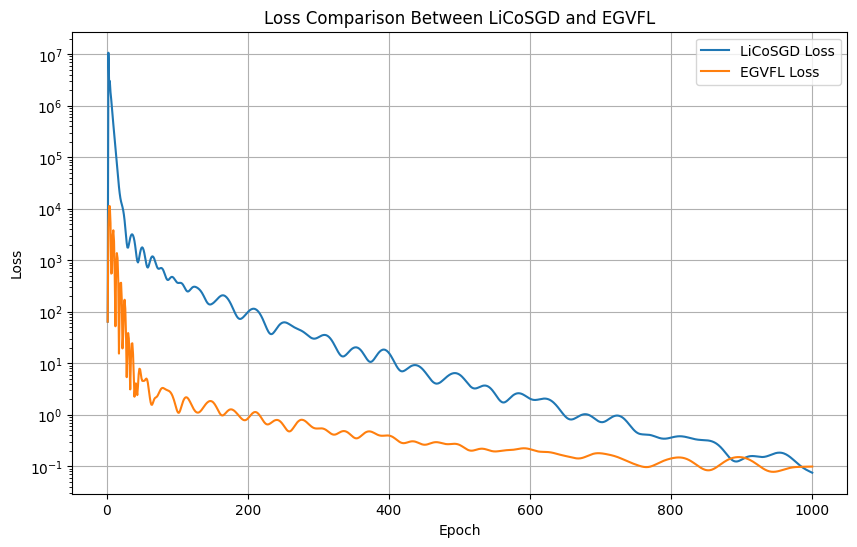

In [525]:
skipped = 0

plt.figure(figsize=(10, 6))
plt.yscale("log")
plt.plot(range((skipped + 1) * batch_size, (epoches + 1 + 1) * batch_size, batch_size), losses_lico[skipped:], label="LiCoSGD Loss")
plt.plot(range((skipped + 1) * batch_size, (epoches + 1 + 1) * batch_size, batch_size), losses_egvfl[skipped:], label="EGVFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Comparison Between LiCoSGD and EGVFL")
plt.legend()
plt.grid()
plt.show()

tensor(1.)

In [ ]:
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss

epoches = 100
batch_size = 100
losses = []

for epoch in range(epoches):
    avg_loss = 0.0
    for batch in range(batch_size):
        algo.step()
        avg_loss += mse_loss(algo.predict(), centr.labels).item()
    avg_loss /= batch_size
    losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{epoches} completed. Loss: {avg_loss}")

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoches + 1), losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

Epoch 1/100 completed. Loss: 317.7603866624832
Epoch 2/100 completed. Loss: 2994.1151794433595
Epoch 3/100 completed. Loss: 8110.639262695313
Epoch 4/100 completed. Loss: 14007.168876953125
Epoch 5/100 completed. Loss: 18768.041171875
Epoch 6/100 completed. Loss: 20846.962265625
Epoch 7/100 completed. Loss: 19570.5766015625
Epoch 8/100 completed. Loss: 15356.560849609376
Epoch 9/100 completed. Loss: 9575.518466796875
Epoch 10/100 completed. Loss: 4102.3959606933595
Epoch 11/100 completed. Loss: 704.3761010169983
Epoch 12/100 completed. Loss: 465.35306546211245
Epoch 13/100 completed. Loss: 3434.7575476074217
Epoch 14/100 completed. Loss: 8614.902583007812
Epoch 15/100 completed. Loss: 14290.246845703125
Epoch 16/100 completed. Loss: 18590.32625
Epoch 17/100 completed. Loss: 20101.999765625
Epoch 18/100 completed. Loss: 18330.8608203125
Epoch 19/100 completed. Loss: 13861.33869140625
Epoch 20/100 completed. Loss: 8163.716611328125
Epoch 21/100 completed. Loss: 3111.6983349609377
Epoch 2

KeyboardInterrupt: 